## CMPE 188 Project 
<b>Team:</b> Team Alpha Super Awesome Cool Dynamite Wolf Squadron (TASACDWS)<br>
<b>Members:</b> Alam Figueroa, Kevin Gomez, Rachel Stanik<br>
<b>Description:</b> <br>
<b>Kaggle competition:</b> https://www.kaggle.com/c/ashrae-energy-prediction <br>

Notebook adapted from: https://www.kaggle.com/c/ashrae-energy-prediction/data

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
import gc

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split as train_valid_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

import eli5
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Import the datasets
### Datasets Descriptions
Referenced this kaggle notebook: https://www.kaggle.com/pednt9/ashrae-handling-missing-values/comments <br>
#### train.csv
* <b>Description:</b> contains the main training data for the model
* <b>Size:</b> 647.18 MB
* <b>Number of Records:</b> 20,216,102.
* <b>Features:</b> (building_id, meter, timestamp, meter_reading)

#### building_meta.csv
* <b>Description:</b> contains metadata about each building
* <b>Size:</b> 46KB
* <b>Number of Records:</b> 1148
* <b> 6 Features: </b> (site_id, building_id, primary_use, square_feet, year_built, floor_count)

#### weather_[train/test].csv
* <b>Description:</b> Weather data from a meteorological station as close as possible to the site.
* <b>Size:</b> 7.5MB /14.8MB respectively
* <b>Number of Records: </b>
* <b>9 Features: </b> (site_id, timestamp, air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_direction, wind_speed

#### test.csv
* <b>Description:</b> The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

#### sample_submission.csv
* <b>Description:</b> A valid sample submission.

### Train.csv dataset
This section will include data cleaning for the train.csv dataset. Also, included in this section is the analysis of meter reading in relation to buildings

For data cleaning we need to change timestamp from object to datetime. Change meter to catgories, since its the 4 energy types that the data description was talking about

In [3]:
energy = pd.read_csv('data/train.csv')
energy.timestamp = pd.to_datetime(energy.timestamp)
energy.meter = energy.meter.astype('category')
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            category
timestamp        datetime64[ns]
meter_reading    float64
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 482.0 MB


We want to know if the rows for each building are equally distributed. As we can see below that around 700 buildings have around 8000 rows, but we can also see some building ids that have 35000 rows in the dataframe

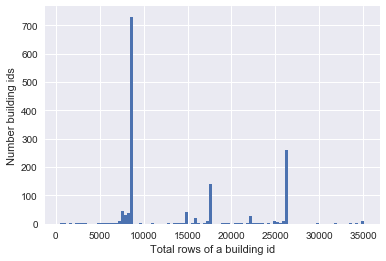

In [4]:
g = energy.building_id.value_counts()
plt.hist(g.values,bins=100)
plt.xlabel('Total rows of a building id')
plt.ylabel('Number building ids')
plt.show()

Meter is the 4 types of energy that the data description was talking about... As we can see here Meter Type 0 is the dominant type for all buildings.

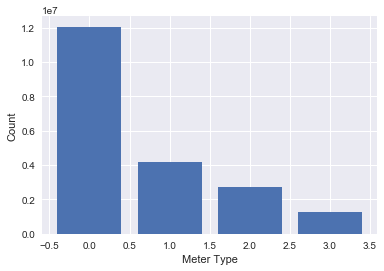

In [5]:
g = energy.meter.value_counts()
plt.bar(g.index,g.values)
plt.xlabel('Meter Type')
plt.ylabel('Count')
plt.show()

Since the meter reading varies a lot. We can see the distribution by getting the log of the values to remove the huge differences.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


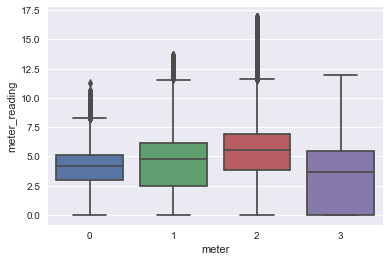

In [6]:
g = energy[['meter','meter_reading']]
g['meter_reading'] = np.log1p(g['meter_reading'])
sns.boxplot(x='meter',y='meter_reading',data=g)
plt.plot();

### Weather_train.csv
This section will include data cleaning for the weather_train.csv dataset. Also, included in this section is the analysis of weather variables

For data cleaning we need to change timestamp from object to datetime.

In [7]:
weather = pd.read_csv('data/weather_train.csv')
weather.timestamp = pd.to_datetime(weather.timestamp)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


In terms of correlation of weather variables, only the air and dew temperature have significant correlation

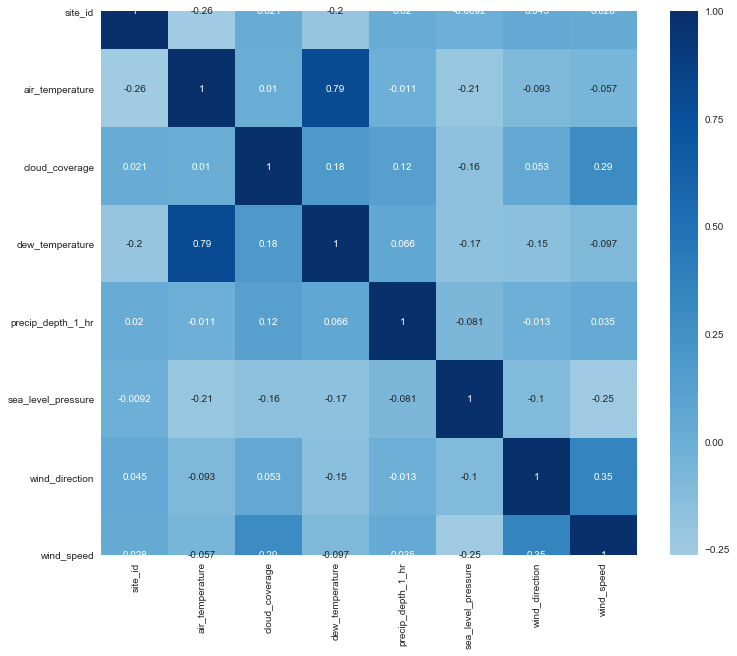

In [8]:
g = weather.drop(['timestamp'],axis=1).corr()
plt.figure(figsize=(12,10))
sns.heatmap(g,annot=True,center=0,cmap='Blues');

### Building_metadata.csv
This section will include the analysis of buildings and its variables

In [9]:
building_info = pd.read_csv('data/building_metadata.csv')
building_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


Wow! The dataset contains buildings that were made in the 1900s. I thought the buildings will be just newer ones.

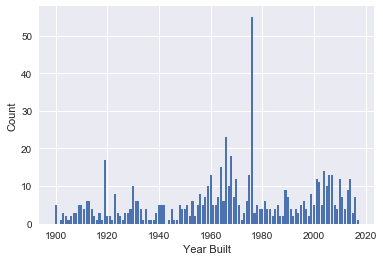

In [10]:
g = building_info.year_built.value_counts()
plt.bar(g.index,g.values)
plt.xlabel('Year Built')
plt.ylabel('Count')
plt.show()

Majority of the buildings' primary usage is for Education

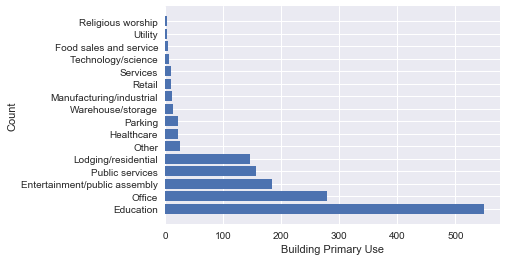

In [11]:
g = building_info.primary_use.value_counts()
plt.barh(g.index,g.values)
plt.xlabel('Building Primary Use')
plt.ylabel('Count')
plt.show()

## Dataset preprocessing

This section will include modeling preparation

### merge the datasets together

In [12]:
train = pd.merge(energy,building_info,on='building_id',how='left')
train = pd.merge(train,weather,on=['site_id','timestamp'],how='left')
del weather
gc.collect()
train.tail()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
20216095,1444,0,2016-12-31 23:00:00,8.750,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216096,1445,0,2016-12-31 23:00:00,4.825,15,Education,4298,NaN,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216097,1446,0,2016-12-31 23:00:00,0.000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216098,1447,0,2016-12-31 23:00:00,159.575,15,Lodging/residential,29775,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216099,1448,0,2016-12-31 23:00:00,2.850,15,Office,92271,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


### Convert the timestamp to datetime

In [13]:
def dt_parts(df,dt_col):
    if(df[dt_col].dtype=='O'):
        df[dt_col] = pd.to_datetime(df[dt_col])
    df['year'] = df[dt_col].dt.year.astype(np.int16)
    df['month'] = df[dt_col].dt.month.astype(np.int8)
    df.drop(dt_col,axis=1,inplace=True)
    return df
train = dt_parts(train, 'timestamp')

### Fill in missing values

In [14]:
def fill_missing_vals(train):
    #forward fill and backwards fill for missing values
    train = train.apply(lambda x: x.ffill())
    train = train.apply(lambda x: x.bfill())
    return train
train = fill_missing_vals(train)
train.isnull().sum()

building_id           0
meter                 0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
year                  0
month                 0
dtype: int64

### Drop unnecessary information

In [15]:
train.set_index(['building_id'])
# drop unnecessary factors
train = train.drop(columns=['site_id', 'year', 'building_id'])
train.tail()

,meter,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month
20216095,0,8.750,Entertainment/public assembly,19619,1914.0,4.0,1.7,4.0,-5.6,-1.0,1008.5,180.0,8.8,12
20216096,0,4.825,Education,4298,1914.0,4.0,1.7,4.0,-5.6,-1.0,1008.5,180.0,8.8,12
20216097,0,0.000,Entertainment/public assembly,11265,1997.0,4.0,1.7,4.0,-5.6,-1.0,1008.5,180.0,8.8,12
20216098,0,159.575,Lodging/residential,29775,2001.0,4.0,1.7,4.0,-5.6,-1.0,1008.5,180.0,8.8,12
20216099,0,2.850,Office,92271,2001.0,4.0,1.7,4.0,-5.6,-1.0,1008.5,180.0,8.8,12


### Reduce size of remaining columns for memory space

In [16]:
#optimizing the column types to consume less space
def df_type_optimize(df):
    #df['building_id'] = df['building_id'].astype(np.uint16)
    df['meter'] = df['meter'].astype(np.uint8)
    #df['site_id'] = df['site_id'].astype(np.uint8)
    df['square_feet'] = df['square_feet'].astype(np.uint32)
    
    df['year_built'] = df['year_built'].astype(np.uint16)
    df['floor_count'] = df['floor_count'].astype(np.uint8)
    
    df['air_temperature'] = df['air_temperature'].astype(np.int16)
    df['cloud_coverage'] = df['cloud_coverage'].astype(np.int16)
    df['dew_temperature'] = df['dew_temperature'].astype(np.int16)
    df['precip_depth_1_hr'] = df['precip_depth_1_hr'].astype(np.int16)
    df['sea_level_pressure'] = df['sea_level_pressure'].astype(np.int16)
    df['wind_direction'] = df['wind_direction'].astype(np.int16)
    df['wind_speed'] = df['wind_speed'].astype(np.int16)
    
    return df

In [17]:
train['primary_use'] = train['primary_use'].astype('category').cat.codes
train=df_type_optimize(train)
train.head()

,meter,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month
0,0,0.0,0,7432,2008,5,25,6,20,-1,1019,0,0,1
1,0,0.0,0,2720,2004,5,25,6,20,-1,1019,0,0,1
2,0,0.0,0,5376,1991,5,25,6,20,-1,1019,0,0,1
3,0,0.0,0,23685,2002,5,25,6,20,-1,1019,0,0,1
4,0,0.0,0,116607,1975,5,25,6,20,-1,1019,0,0,1


### Normalize the data for linear regression
Reference: https://www.kaggle.com/parasjindal96/how-to-normalize-dataframe-pandas <br>
Normalizes in the range of 0 - 1

In [18]:
def normalize(dataset, ignored_columns):
    dataNorm=(dataset-dataset.min())/(dataset.max()-dataset.min())
    for ignored_col in ignored_columns:
        dataNorm[ignored_col] = dataset[ignored_col]
    return dataNorm
train = normalize(train, ['meter_reading'])
train.tail()
train.isnull().sum()

meter                 0
meter_reading         0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
month                 0
dtype: int64

### test-train split

In [19]:
target_col = 'meter_reading'
data_y = train[target_col]
data_x = train.drop(target_col,axis=1)

X_train, X_valid, y_train, y_valid = train_valid_split(data_x, data_y, test_size=0.2, random_state=0)
del train
gc.collect()

X_train.shape,X_valid.shape

((16172880, 13), (4043220, 13))

## Modeling

Try a RandomForestRegressor or LinearRegression model <br>
For RandomForestRegressor: Due to Memory Error problems, I used this solution to reducing sub-sample size of random forest in sklearn <br/> [How can I set sub-sample size in Random Forest Classifier in Scikit-Learn? Especially for imbalanced data](https://stackoverflow.com/questions/44955555/how-can-i-set-sub-sample-size-in-random-forest-classifier-in-scikit-learn-espec#50914280) 

In [20]:
#code reference above
from sklearn.ensemble import forest
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
set_rf_samples(130000)

In [21]:
%%time
model = RandomForestRegressor(n_estimators=60,
                              random_state=0,n_jobs=-1)

#try a linear regression model instead
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
model.fit(X_train,y_train)

CPU times: user 3min 34s, sys: 14.8 s, total: 3min 49s
Wall time: 38.8 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

### Evaluation
https://www.kaggle.com/c/ashrae-energy-prediction/overview/evaluation

Use RMSLE for evaluation

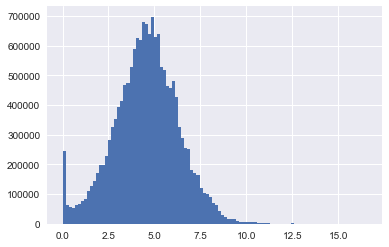

train_rmsle:  1.2400271800666278


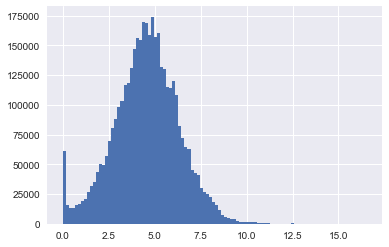

valid_rmsle:  1.2404348725857541


In [22]:
def RMSLE(actual,preds):
    return np.sqrt(mean_squared_log_error(actual,preds))

def get_evaluations(model):
    preds = model.predict(X_train)
    plt.hist(np.log1p(preds),bins=100)
    plt.show();
    print('train_rmsle: ',RMSLE(y_train,abs(preds)))
                    
    preds = model.predict(X_valid)
    plt.hist(np.log1p(preds),bins=100)
    plt.show()
    print('valid_rmsle: ',RMSLE(y_valid,abs(preds)))
    
get_evaluations(model)

## Model Interpretation

This section we will utilize different technique to know how the model make its decision based from the data.
Insights from this section can be useful for optimal feature engineering and improving the model accuracy.


### Feature Weights
We can see here that the month,meter,dew_temperature,square_feet have top weight in the random forest

In [23]:
eli5.show_weights(model,feature_names=list(X_train.columns))

Weight,Feature
0.2337 ± 0.1795,month
0.1801 ± 0.1515,meter
0.1545 ± 0.2312,dew_temperature
0.1326 ± 0.0632,square_feet
0.1325 ± 0.2271,air_temperature
0.0579 ± 0.1224,sea_level_pressure
0.0374 ± 0.0926,wind_direction
0.0248 ± 0.0774,wind_speed
0.0232 ± 0.1042,precip_depth_1_hr
0.0231 ± 0.0708,cloud_coverage


### Explaining model predictions

Out sample will be from out validation set. We can see here the contribution of each feature to the model's prediction of meter reading.

In [24]:
test_row = X_valid.loc[15256244,:]
test_row

meter                 0.000000
primary_use           0.600000
square_feet           0.395047
year_built            0.564103
floor_count           0.280000
air_temperature       0.586667
cloud_coverage        0.000000
dew_temperature       0.622951
precip_depth_1_hr     0.002907
sea_level_pressure    0.519481
wind_direction        0.250000
wind_speed            0.052632
month                 0.818182
Name: 15256244, dtype: float64

In [25]:
eli5.show_prediction(model,test_row,feature_names=list(X_train.columns))

## Submission Pipeline

In [28]:
energy_test = pd.read_csv('data/test.csv')
weather_test = pd.read_csv('data/weather_test.csv')
test = pd.merge(energy_test,building_info,on='building_id',how='left')
test = pd.merge(test,weather_test,on=['site_id','timestamp'],how='left')
del energy_test,weather_test
test.tail()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
41697595,41697595,1444,0,2018-05-09 07:00:00,15,Entertainment/public assembly,19619,1914.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697596,41697596,1445,0,2018-05-09 07:00:00,15,Education,4298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697597,41697597,1446,0,2018-05-09 07:00:00,15,Entertainment/public assembly,11265,1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697598,41697598,1447,0,2018-05-09 07:00:00,15,Lodging/residential,29775,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697599,41697599,1448,0,2018-05-09 07:00:00,15,Office,92271,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prep the test data
convert the timestamp <br>
fill in missing values <br>
drop unnecessary rows <br>
optimize the datatypes to improve memory usage <br>
normalize the data

In [29]:
test['primary_use'] = test['primary_use'].astype('category').cat.codes
test = dt_parts(test,'timestamp')

test = fill_missing_vals(test)

test = test.drop(columns=['year', 'site_id', 'building_id'])

test=df_type_optimize(test)

test = normalize(test, ['row_id'])

ids = test['row_id']
test.drop('row_id',axis=1,inplace=True)
test.head()

,meter,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month
0,0.0,0.0,0.008173,0.923077,0.16,0.592105,0.444444,0.736842,0.001672,0.628205,0.277778,0.125,0.0
1,0.0,0.0,0.002786,0.888889,0.16,0.592105,0.444444,0.736842,0.001672,0.628205,0.277778,0.125,0.0
2,0.0,0.0,0.005822,0.777778,0.16,0.592105,0.444444,0.736842,0.001672,0.628205,0.277778,0.125,0.0
3,0.0,0.0,0.026754,0.871795,0.16,0.592105,0.444444,0.736842,0.001672,0.628205,0.277778,0.125,0.0
4,0.0,0.0,0.132985,0.641026,0.16,0.592105,0.444444,0.736842,0.001672,0.628205,0.277778,0.125,0.0


In [33]:
%%time
preds = model.predict(test)

# round to 4 decimal places to save space
preds = np.round(preds, decimals=4)


CPU times: user 11min 33s, sys: 1min 35s, total: 13min 9s
Wall time: 2min 26s


In [34]:
sub_df = pd.DataFrame()
sub_df['row_id'] = ids
sub_df['meter_reading'] = preds
sub_df.to_csv('the-sub-mission.csv',index=False)
sub_df.head()

,row_id,meter_reading
0,0,0.0000
1,1,0.5415
2,2,0.0000
3,3,41.4404
4,4,1.0538


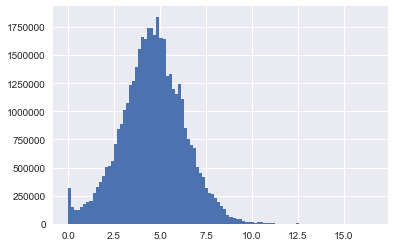

In [35]:
plt.hist(np.log1p(sub_df['meter_reading']),bins=100)
plt.show()